# **Problem set 5** - Machine Learning for Physics and Astronomy 2023/2024, UvA

- The total sheet gives 30 points
- Deadline for submitting your results is **Wed, 23/5/2024, 23:59**
- **IMPORTANT**: Specify if/how AI was used to solve the exercises by filling the corresponding "Usage of AI" comments. Anything between "No" (if applicable) and a short paragraph reflecting how AI was used is fine. Failing to do so faithfully will result in the substraction of points.

### Remember, if you get the error "No CUDA GPUs are available," go to Runtime > Change runtime type > select GPU.

## Chapter 9: Simulation-Based Inference (22 pt)

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

### 1. Measuring Rings (7 pt)

In the last homework session we classified numbers on the MNIST dataset, but this is not representative of the types of tasks that we use neural neutworks for in physics. So we now move on to a different task: measuring the radius of rings produced by a simulator. We define a function that serves as our "simulator," `image_model` which produces images with one or more rings, where the radius, width, and number of rings are simulation parameters.

This model is a toy model for producing simulated images of graviationally lensed systems.  The radius would then correspond to the "Einstein radius" of the [gravitational lensing system](https://en.wikipedia.org/wiki/Einstein_ring) and tell us something about the mass of the lensing galaxy. The width would correspond to the size of the lensed source galaxy.  Normally, you would not get multiple rings in one image, but in our toy model we add this possibility to test just how difficult we can make the problem while still learning the parameters.

As an example, a real strong lensing image looks like this:

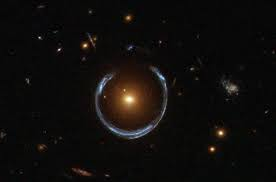

So now we define our "simulator."

In [2]:
def image_model(radius = 0.5, sigma = 0.3, width = 0.15, n = 1):
    x = np.linspace(-2, 2, 32)
    X, Y = np.meshgrid(x, x)

    # Random position of the ring
    imgs = []
    for i in range(n):
      x0, y0 = np.random.uniform(-1, 1, 2)

      R = ((X-x0)**2 + (Y-y0)**2)**0.5
      img = np.exp(-(R-radius)**2/width**2/2)
      img = img

      imgs.append(img)

    # Standard variance and zero mean
    img = sum(imgs)

    # Remove mean and variance
    img -= img.mean()
    img /= img.std()

    # Add image noise
    img += np.random.randn(*img.shape)*sigma


    return img.reshape(1, 32, 32).astype(np.float32)  # Default CUDA tensors are float32

Next, we next generate our training and test data. In this case, 50000 examples.

In [3]:
ring_data = []
for i in range(50000):
  r = np.random.rand(1).astype(np.float32)
  img = image_model(n = 3, radius = r)
  ring_data.append((img, r))

class RingDataset(torch.utils.data.Dataset):
  def __init__(self, ring_data):
    self.ring_data = ring_data

  def __getitem__(self, idx):
    return self.ring_data[idx]

  def __len__(self):
    return len(self.ring_data)

ring_dataset_train = RingDataset(ring_data[:45000])
ring_dataset_test = RingDataset(ring_data[45000:])

We then instantiate the loaders.

In [4]:
batch_size_train = 64  # by default we use a minibatch size of 64 for training.
# You can leave it like that during the subsequent exercises.

batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(ring_dataset_train, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ring_dataset_test, batch_size=batch_size_test, shuffle=True)

In [5]:
examples = list(test_loader)
example_data, example_targets = examples[0]

And plot test examples.

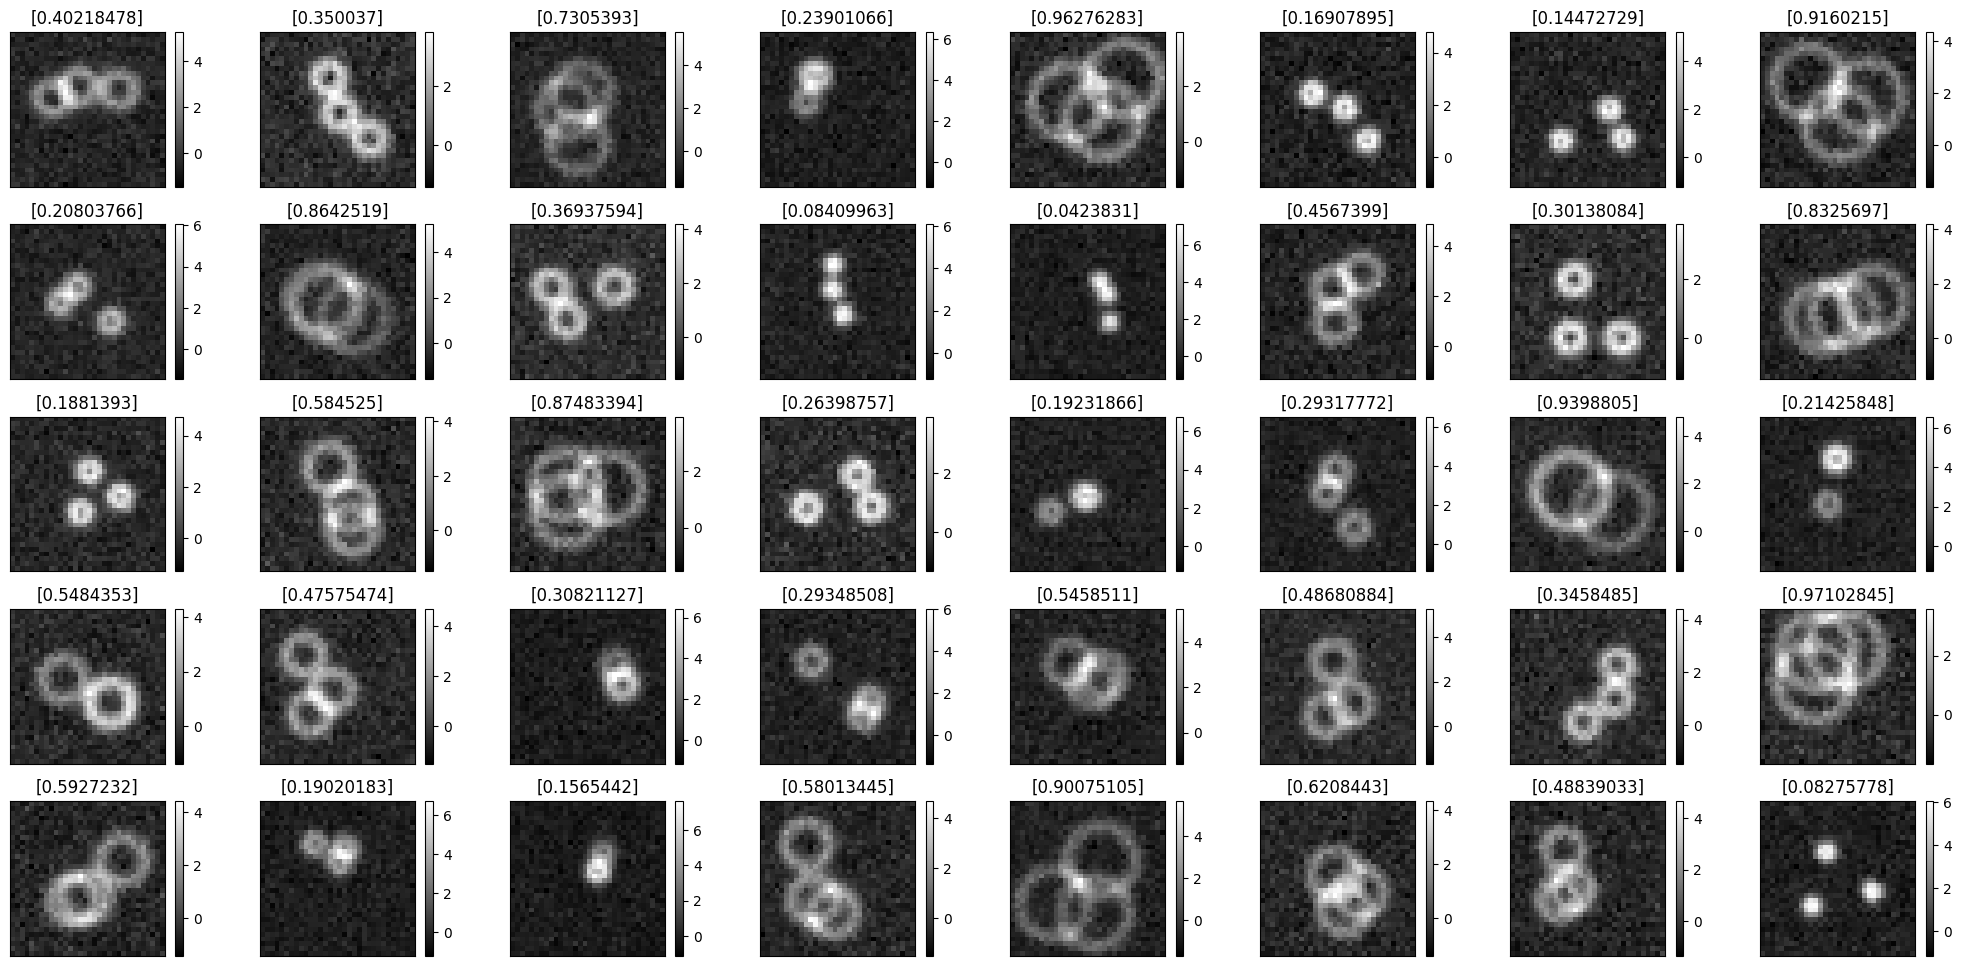

In [6]:
fig = plt.figure(figsize=(20, 10))
for i in range(40):
  plt.subplot(5,8,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("{}".format(example_targets[i].numpy()))
  plt.xticks([])
  plt.yticks([])
  plt.colorbar()

We first start with a regression-based implementation, where we will train a neural network to predict the radius as a single number directly.

1. Regression model. Create a similar CNN to the one used on the MNIST dataset in the last homework. This time it should predict a single real-valued number that represents the radius. (2pt)

HINTS:
 -  If you did not finish the previous exercise scroll down to see another implementation of a CNN.
 - Always remember to count the in- and ouput dimensions of every layer in your CNN. Both `nn.Conv2d`and `nn.functional.max_pool2d`generally change the output dimensions.

In [7]:
# Useful imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class RegressionNet(nn.Module):
    def __init__(self):
        super(RegressionNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = RegressionNet()

2. Before, we were doing classification and so we used the appropriate cross-entropy loss. Now, we must replace the loss with mean square error (MSE) for regression. Define the training loop below with this new loss function. (1pt)

In [8]:
## your code here
n_epochs =2
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]


learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, radii in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, radii.view(-1,1))

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

        # Print average loss for this epoch
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

    # Optional: Evaluate on the test set
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, radii in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, radii.view(-1,1))
            total_loss += loss.item()

    print(f'Test Loss: {total_loss/len(test_loader)}')



3. Train the network on GPU. If everything works, you should see that the loss decreases. (Refer to previous exercises if you need guidance.) (2pt)

Hint: If your network doesn't train, try using a smaller learning rate (e.g. 0.001).

In [9]:
## your code here
## your code here
torch.cuda.is_available()

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')


In [10]:


network = RegressionNet().to(DEVICE)  # We move the network to the GPU




In [11]:
for epoch in range(1, n_epochs + 1):
    train(epoch)

Epoch 1/1, Loss: 0.008116934816329873
Test Loss: 0.0013234812999144197
Epoch 1/2, Loss: 0.001229763761082061
Epoch 2/2, Loss: 0.0008731479609774727
Test Loss: 0.0013735644519329072


4. Illustrate the reconstruction quality by running 1000 test images through the network and recording the outputs.  Show correct (x-axis) vs reconstructed (y-axis) radii in a scatter plot (`plt.scatter`). How well does your network perform? (1pt)

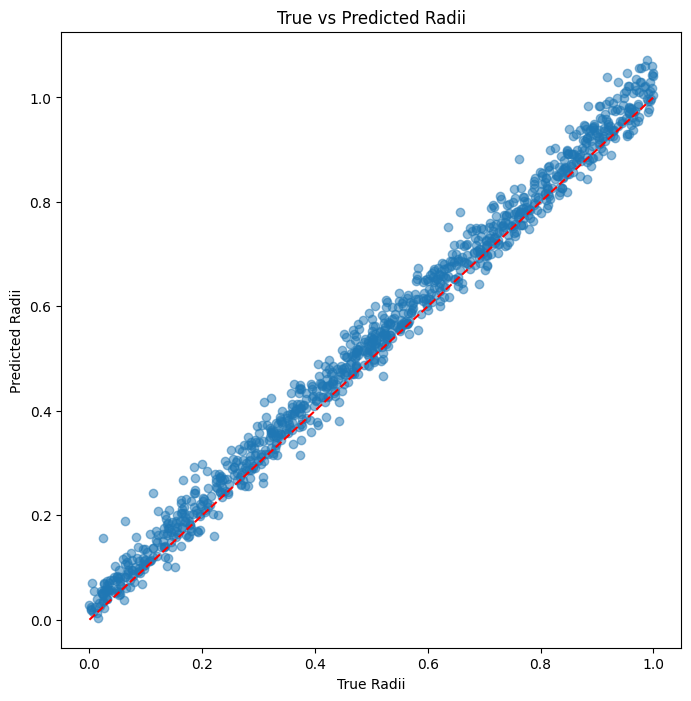

In [12]:
import matplotlib.pyplot as plt

def evaluate_and_plot(model, test_loader, num_samples=1000):
    model.eval()
    true_radii = []
    predicted_radii = []
    count = 0

    with torch.no_grad():
        for inputs, radii in test_loader:
            outputs = model(inputs)
            true_radii.extend(radii.numpy())
            predicted_radii.extend(outputs.view(-1).numpy())
            count += len(radii)
            if count >= num_samples:
                break

    true_radii = true_radii[:num_samples]
    predicted_radii = predicted_radii[:num_samples]

    plt.figure(figsize=(8, 8))
    plt.scatter(true_radii, predicted_radii, alpha=0.5)
    plt.xlabel('True Radii')
    plt.ylabel('Predicted Radii')
    plt.title('True vs Predicted Radii')
    plt.plot([min(true_radii), max(true_radii)], [min(true_radii), max(true_radii)], 'r--')  # Line of perfect prediction
    plt.show()

# Example usage:
# Assuming `model` and `test_loader` are already defined
evaluate_and_plot(model, test_loader, num_samples=1000)


My network behaves quiet linearly with ground truth dataset it seems to underestimate small radi < 0.2 but the remaining spread/noise remains symmetric.

5. Imagine your are provided with a single image, and you have to use your network to estimate the radius of the rings and quote your best estimate together with error bars. Write 2-3 qualitative sentences about how you could obtain this error bar from the plot that you generated in the previous point. (1pt)

I could pass the image into the network and caculate the spread $\sigma$ WRT to the true radius. Then plot at as my error around the true radius.

**Usage** of AI: The network, the training loop, the plotting

### 2. Simulation-based inference of posteriors (11 pt)

In the previous exercise, we predicted a single value for the radius, but this did not tell us anything about the probability of the predicted value. In this exercise, we will use the neural likelihood-free based inference method (focusing on neural ratio estimation) discussed in class to obtain proper Bayesian posteriors for the radius, instead of just a point estimator.

Let's start by defining a neural network that takes as input both an image $x$ as well as a label (in our case radius) $z$.  The output will be the probability that $x$ and $z$ are jointly drawn, $x, z \sim p(x, z)$, rather than marginally, $x, z \sim p(x)p(z)$.

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(501, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x, z):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 500)
        x = torch.cat((x, z), axis = 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

1. What does the `torch.cat` function do in this context? Relate it back to the math dicussed in class.  (1 pt)



`torch.cat` concatenates the two tensors along a specific axis, in our case the y-axis

The dimensions of the two tensors should be the same in all dimensions except axis to concatnate along.

Now we define the optimizer, and instantiate the network.

In [14]:
learning_rate = 0.001
DEVICE = 'cuda'
network = Net().to(DEVICE)  # We move the network to the GPU
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

By default, we will use `n_epochs = 3` throughout.  Leave it like that.

In [15]:
n_epochs = 3  # 3 epochs by default.

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

The main training loop is now given as follows.

In [16]:
log_interval = 10

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = data.to(DEVICE)
    target = target.to(DEVICE)

    output_joined = network(data[1:], target[1:])
    output_marginal = network(data[1:], torch.rand_like(target[1:]))

    loss = -torch.log(output_joined) - torch.log(1-output_marginal)
    loss = loss.sum()

    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

2. Explain the role of the two different `output` variables, and how those enter the binary cross-entropy loss function. Write down the mathematical definition of the loss function that we implement (in terms of an integral). (1 pt)

output_joined shows and example of a joined probability where $\vec{x},z, ≈  p(\vec{x},z) $ come from the same probability distribution

Output mariginal come from two indepedent draws of the probabiilty distriubtion $\vec{x},z, ≈  p(\vec{x}),p(z) $

In [17]:
for epoch in range(1, n_epochs + 1):
  train(epoch)

Train Epoch: 1 [0/45000 (0%)]	Loss: 87.343117
Train Epoch: 1 [640/45000 (1%)]	Loss: 87.361908
Train Epoch: 1 [1280/45000 (3%)]	Loss: 87.305504
Train Epoch: 1 [1920/45000 (4%)]	Loss: 87.282700
Train Epoch: 1 [2560/45000 (6%)]	Loss: 87.258926
Train Epoch: 1 [3200/45000 (7%)]	Loss: 87.209305
Train Epoch: 1 [3840/45000 (9%)]	Loss: 87.102615
Train Epoch: 1 [4480/45000 (10%)]	Loss: 86.890266
Train Epoch: 1 [5120/45000 (11%)]	Loss: 86.809494
Train Epoch: 1 [5760/45000 (13%)]	Loss: 86.607361
Train Epoch: 1 [6400/45000 (14%)]	Loss: 86.272835
Train Epoch: 1 [7040/45000 (16%)]	Loss: 85.990417
Train Epoch: 1 [7680/45000 (17%)]	Loss: 85.669571
Train Epoch: 1 [8320/45000 (18%)]	Loss: 85.090332
Train Epoch: 1 [8960/45000 (20%)]	Loss: 85.467148
Train Epoch: 1 [9600/45000 (21%)]	Loss: 84.302811
Train Epoch: 1 [10240/45000 (23%)]	Loss: 83.862595
Train Epoch: 1 [10880/45000 (24%)]	Loss: 83.795670
Train Epoch: 1 [11520/45000 (26%)]	Loss: 82.793503
Train Epoch: 1 [12160/45000 (27%)]	Loss: 81.059341
Train E

3. Write some code to plot, for a given image, the posterior of the radius. To this end, the network should be evaluated for the same $x$ and for a continuous range of $z$'s (i.e. radii).  Plot the posterior for 10 different images, together with the true values as a vertical line (`plt.axvline`). Hint: check how the data were generated to remind yourself of the allowed radii in our synthetic dataset. Make sure to correctly normalize the posterior to one (neural ratio estimation provides posteriors that are only approximately normalized to one). (3 pt)

In [18]:
## your code here

4. For each image in the test dataset, derive a posterior and then the boundaries of the 68% credible interval (highest posterior density interval). Next, since our test dataset contains 1000 examples, calculate the fraction of the test examples where the true value lies within the 68% containment interval of the posterior predicted by the neural network. Report this value. Lastly, visualize this by plotting, for each example in the test dataset, a black vertical line representing the containment interval on a plot where the x_axis indicates the true values of the radius and the y-axis represens the NN-predicted values. (3pts)

Hint: your plot should look something like this in the end:

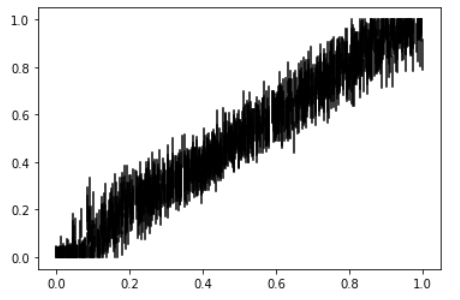

In [19]:
## your code here

5. Repeat part of the previous exercise for 95% and 99% credible intervals and estimate the fraction of training data examples where the true value is contained in the credible interval (no visualization like in the previous exercise required).  Discuss whether your posterior estimation is conservative or overconfident (3 pt).


In [20]:
## your code here

YOUR ANSWER HERE

**Usage** of AI: *COMMENT HERE*

### 3. Loss function gymnastics (4 pt)

1. (2 points) The loss function for neural ratio estimation is given by
$$
L=-\mathbb{E}_{x, z \sim p(x, z)}\left[\ln \sigma\left(f_\theta(x, z)\right)\right]-\mathbb{E}_{x, z \sim p(x) p(z)}\left[\ln \sigma\left(-f_\theta(x, z)\right)\right] .
$$

We claimed in the lecture that minimizing the loss will lead to a $f_\theta(x, z) \approx \ln r(x, z)$, with the likelihood-to-evidence ratio $r(x, z) \equiv \frac{p(x, z)}{p(x) p(z)}$. Show that minimizing the loss w.r.t. $\theta$ indeed yields $\ln r(x, z)$. Explain all steps of your calculation.

2. (2 points) After warming up with the NRE loss, now consider the bivariate probability distribution $p(x, y)$ and the loss function
$$
L\left[M_\phi\right]=\int d x d y p(x, y)\left(x-M_\phi(y)\right)^2,
$$
where $M_\phi(y)$ denotes a flexible neural network with 1-dim input and 1-dim output, parametrized through the parameters $\phi$.

Minimize the loss w.r.t. $\phi$ and derive the $M_\phi(y)$  that minimizes $L$.

Google collab is bugging out and i can't upload my solution i added it as a PDF to the canvas submission

**Usage** of AI: None

## Chapter 10: The Variational Auto-Encoder (8 pt)

### 1. Generating numbers (8 pt)

In [21]:
# useful imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In this exercise, we define a simple variational auto-encoder (VAE) to generate images of digits based on the MNIST data set. For simplicity, we first only care about one digit, 3 in this case. Below is some code that only loads images of threes from the MNIST data.

In [22]:
# load the full data set
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# filter dataset to include only digit 3
train_dataset_3 = list(filter(lambda x: x[1] == 3, train_dataset))

# create DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset_3, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12793601.20it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 350904.36it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2773728.02it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10577750.57it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



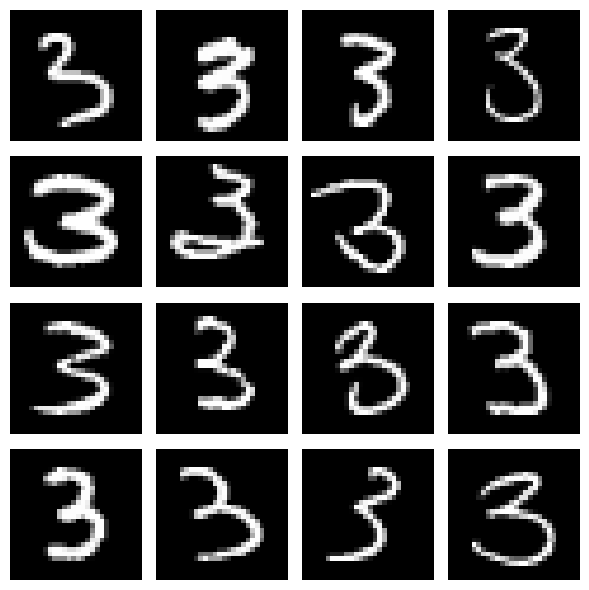

In [23]:
# get a batch of images from train_loader
images, labels = next(iter(train_loader))

# check visually whether this was successful
plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i][0].numpy().squeeze(), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

We now use Pytorch to define a VAE. Usually, VAEs use a convolutional encoder, but in our case, a fully connected layer will also do the job.

In [24]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        # define the encoder part
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2*latent_dim)  # mean and log-variance for each latent variable
        )

        # define the decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Ensure outputs are between 0 and 1 (like MNIST images)
        )

    # invoke the reparametrisation trick
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        enc_output = self.encoder(x)
        mu, logvar = enc_output[:, :latent_dim], enc_output[:, latent_dim:]
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

We are now ready to train the network!

In [25]:
# Define hyperparameters
input_dim = 784  # 28x28 MNIST images
hidden_dim = 400
latent_dim = 5
epochs = 20
learning_rate = 1e-3

# initialize VAE model, optimizer and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# define the loss function
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x.view(-1, input_dim), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data.view(-1, 784))
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('Epoch {}: Average Loss: {:.4f}'.format(epoch+1, train_loss / len(train_loader.dataset)))

Epoch 1: Average Loss: 55.0258
Epoch 2: Average Loss: 37.1178
Epoch 3: Average Loss: 33.5609
Epoch 4: Average Loss: 32.3308
Epoch 5: Average Loss: 31.7470
Epoch 6: Average Loss: 31.3502
Epoch 7: Average Loss: 31.1045
Epoch 8: Average Loss: 30.9266
Epoch 9: Average Loss: 30.7121
Epoch 10: Average Loss: 30.6406
Epoch 11: Average Loss: 30.4099
Epoch 12: Average Loss: 30.3179
Epoch 13: Average Loss: 30.1582
Epoch 14: Average Loss: 30.0103
Epoch 15: Average Loss: 29.9336
Epoch 16: Average Loss: 29.8113
Epoch 17: Average Loss: 29.6332
Epoch 18: Average Loss: 29.5418
Epoch 19: Average Loss: 29.4531
Epoch 20: Average Loss: 29.4263


Having trained our model, we can ask it to generate new instances of the digit 3. Let's check whether it can do this successfully!

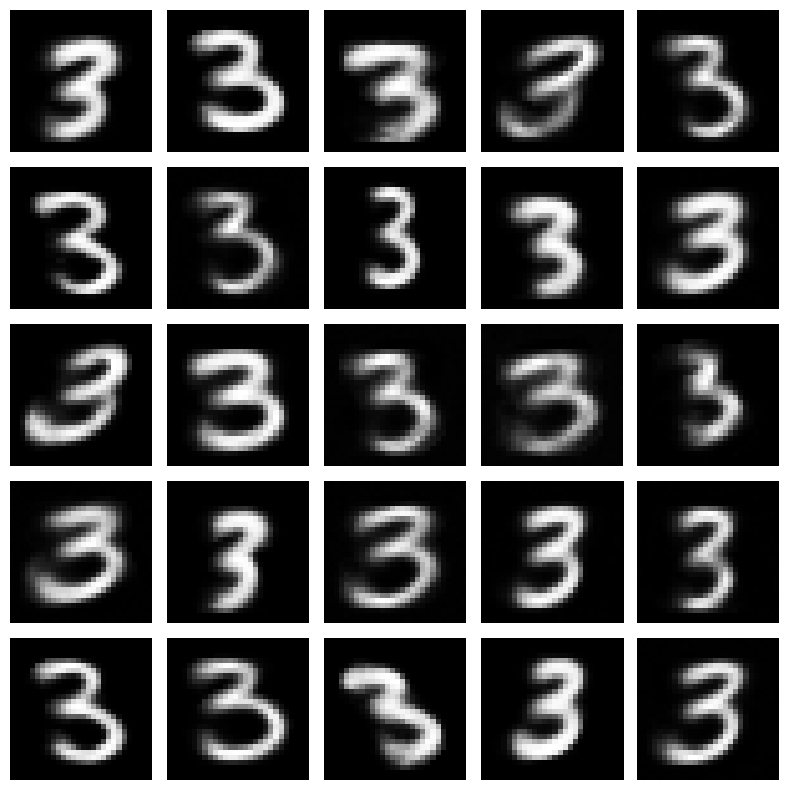

In [26]:
# generate samples
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    generated_samples = model.decoder(z).cpu().view(-1, 1, 28, 28)

# visualize generated samples
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(generated_samples[i].numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

Congrats on generating some 'handwritten' threes that nobody actually has ever written! In the rest of this exercise, we ask you to explore some properties of this VAE. Feel free to use the above code and to adjust it accordingly for the following questions.

1. (3 points) Study how the size of the latent space affects the performance of the VAE. Specifically, do the following:
- show generated samples for three choices of the size of the latent space. Make sure that the sizes differ significantly;
- comment on the differences between the three different sets of results;
- based on these observations, briefly explain what role the size of the latent space has in this application.

Latent dim = 5


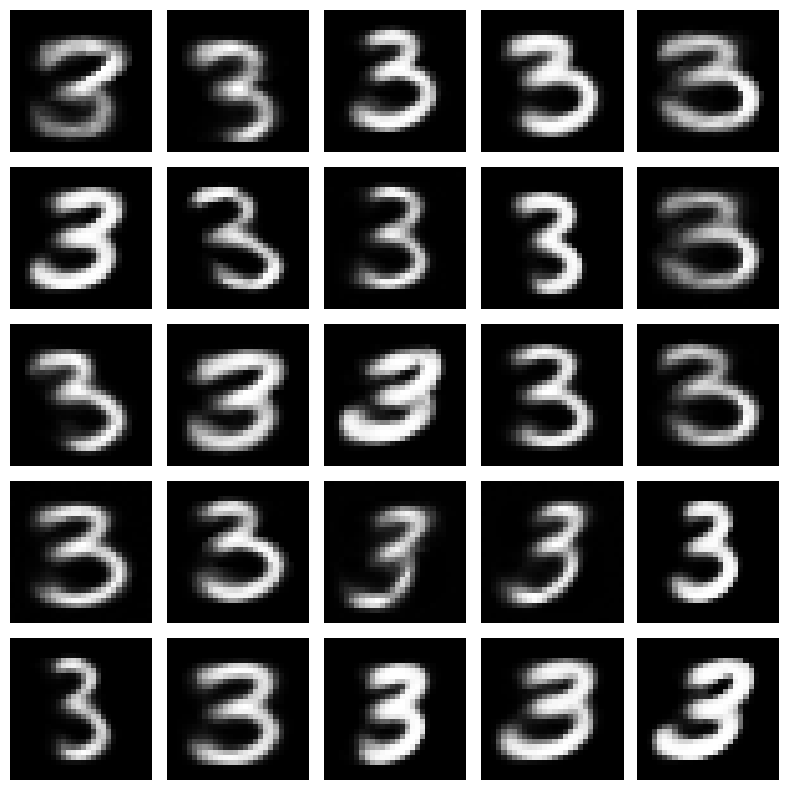

Latent dim = 100


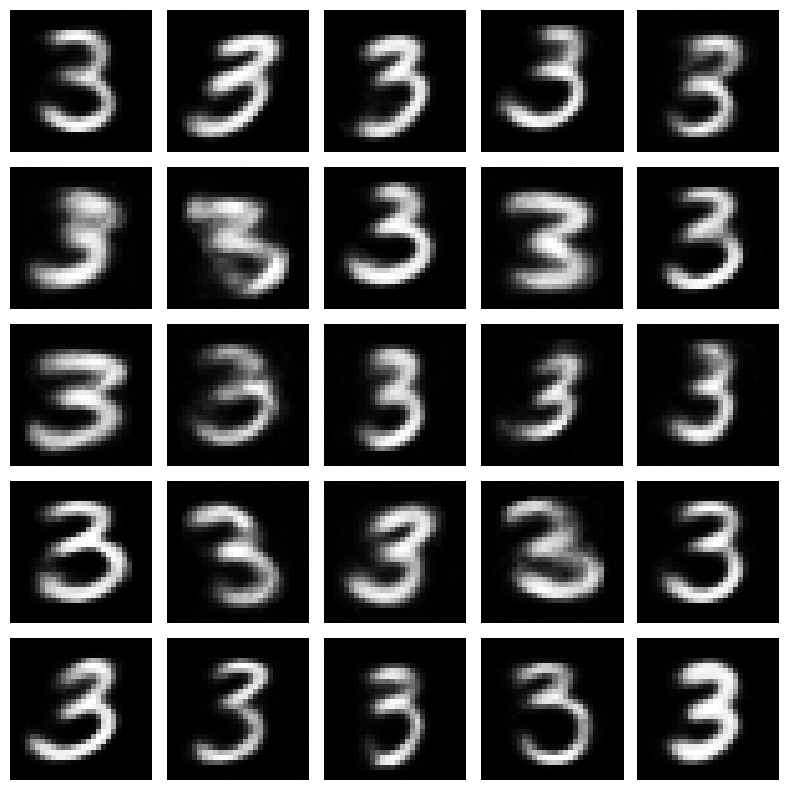

Latent dim = 500


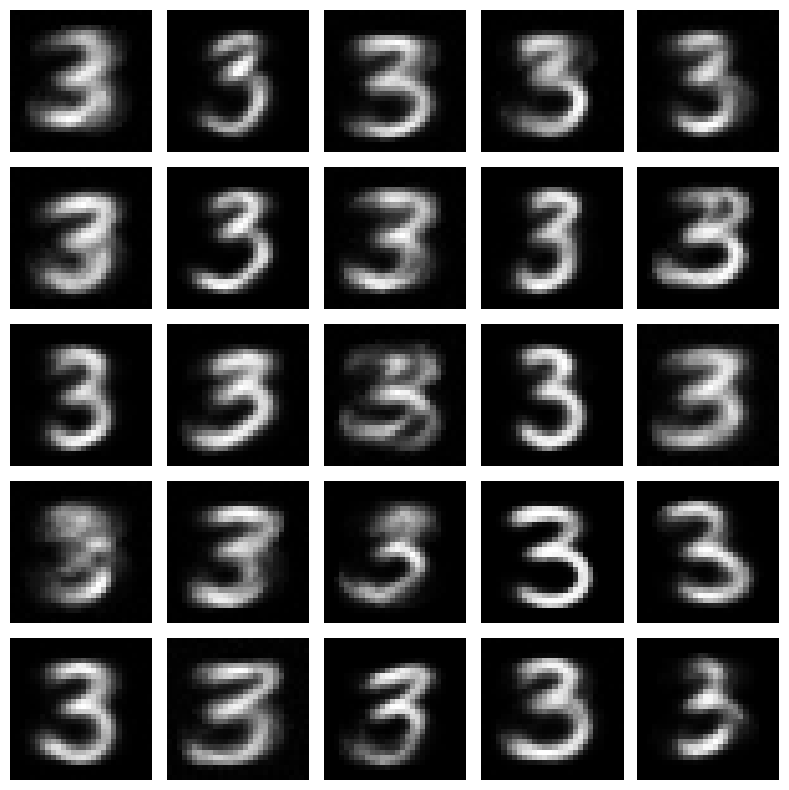

In [27]:
def latent_trail(latent_dim):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = VAE(input_dim, hidden_dim, latent_dim).to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # define the loss function
  def loss_function(recon_x, x, mu, logvar):
      MSE = F.mse_loss(recon_x, x.view(-1, input_dim), reduction='sum')
      KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
      return MSE + KLD

  # Training loop
  for epoch in range(epochs):
      model.train()
      train_loss = 0
      for batch_idx, (data, _) in enumerate(train_loader):
          data = data.to(device)
          optimizer.zero_grad()
          recon_batch, mu, logvar = model(data.view(-1, 784))
          loss = loss_function(recon_batch, data, mu, logvar)
          loss.backward()
          train_loss += loss.item()
          optimizer.step()

  with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    generated_samples = model.decoder(z).cpu().view(-1, 1, 28, 28)

      # visualize generated samples
    plt.figure(figsize=(8, 8))
    for i in range(25):
          plt.subplot(5, 5, i + 1)
          plt.imshow(generated_samples[i].numpy().reshape(28, 28), cmap='gray')
          plt.axis('off')
    plt.tight_layout()
    plt.show()
    return None
latent_dims = [5,100,500]
for latent_dim in latent_dims:
  print("Latent dim = "+str(latent_dim))
  latent_trail(latent_dim)

My choice of latent dimensions are (5, 100, 500). For each model we notice the image begins to smear, it seems like the VAE has trouble finding the largest eigenvalues for increasing dimension, so it cannot find the 'direction' of the image. Latent dimensions seems to increase the spread of the covraince matrix.

2. (3 points) So far, we have only trained the VAE on generating one digit. We now explore whether it can learn more. For that purpose, do the following:

- train the VAE to generate two digits of your choice. Show the results and comment on whether the VAE succeeds at this task;
- try to improve the VAE's performance on the previous task (that is, generating two different digits). Mention which hyperparameters you change, show your results and mention whether you indeed improved the performance;
- train the VAE on the full MNIST data set (so on all 10 digits). Show your results and briefly discuss the VAE's performance.

In [28]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)


#Train for 2

In [33]:
def number_training(number,train_dataset):

  train_dataset = list(filter(lambda x: x[1] == number, train_dataset))

  # create DataLoader
  batch_size = 64
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  images, labels = next(iter(train_loader))

  # check visually whether this was successful
  plt.figure(figsize=(6, 6))
  for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.suptitle("Ground Truth")
    plt.imshow(images[i][0].numpy().squeeze(), cmap='gray')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

  input_dim = 784  # 28x28 MNIST images
  hidden_dim = 500
  latent_dim = 10
  epochs = 25
  learning_rate = 1e-3
  class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        # define the encoder part
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2*latent_dim)  # mean and log-variance for each latent variable
        )

        # define the decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Ensure outputs are between 0 and 1 (like MNIST images)
        )

    # invoke the reparametrisation trick
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        enc_output = self.encoder(x)
        mu, logvar = enc_output[:, :latent_dim], enc_output[:, latent_dim:]
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

  # initialize VAE model, optimizer and loss function
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = VAE(input_dim, hidden_dim, latent_dim).to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # define the loss function
  def loss_function(recon_x, x, mu, logvar):
      MSE = F.mse_loss(recon_x, x.view(-1, input_dim), reduction='sum')
      KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
      return MSE + KLD

  # Training loop
  for epoch in range(epochs):
      model.train()
      train_loss = 0
      for batch_idx, (data, _) in enumerate(train_loader):
          data = data.to(device)
          optimizer.zero_grad()
          recon_batch, mu, logvar = model(data.view(-1, 784))
          loss = loss_function(recon_batch, data, mu, logvar)
          loss.backward()
          train_loss += loss.item()
          optimizer.step()
  with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    generated_samples = model.decoder(z).cpu().view(-1, 1, 28, 28)

  # visualize generated samples
  plt.figure(figsize=(8, 8))
  for i in range(25):
      plt.subplot(5, 5, i + 1)
      plt.suptitle("Samples")
      plt.imshow(generated_samples[i].numpy().reshape(28, 28), cmap='gray')
      plt.axis('off')
  plt.tight_layout()
  plt.show()
  return None

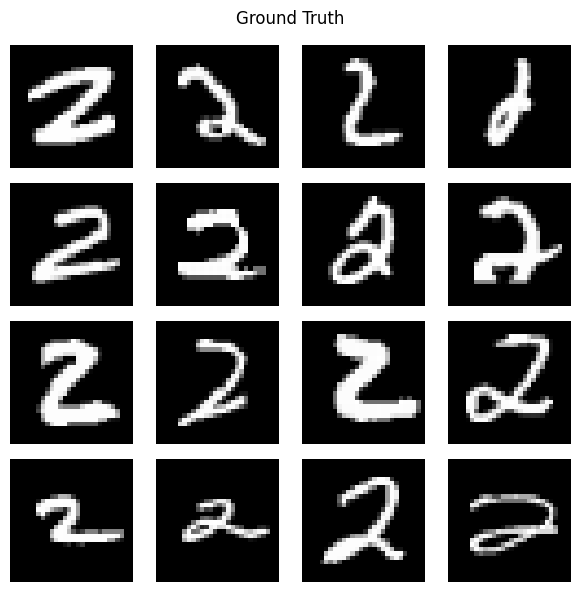

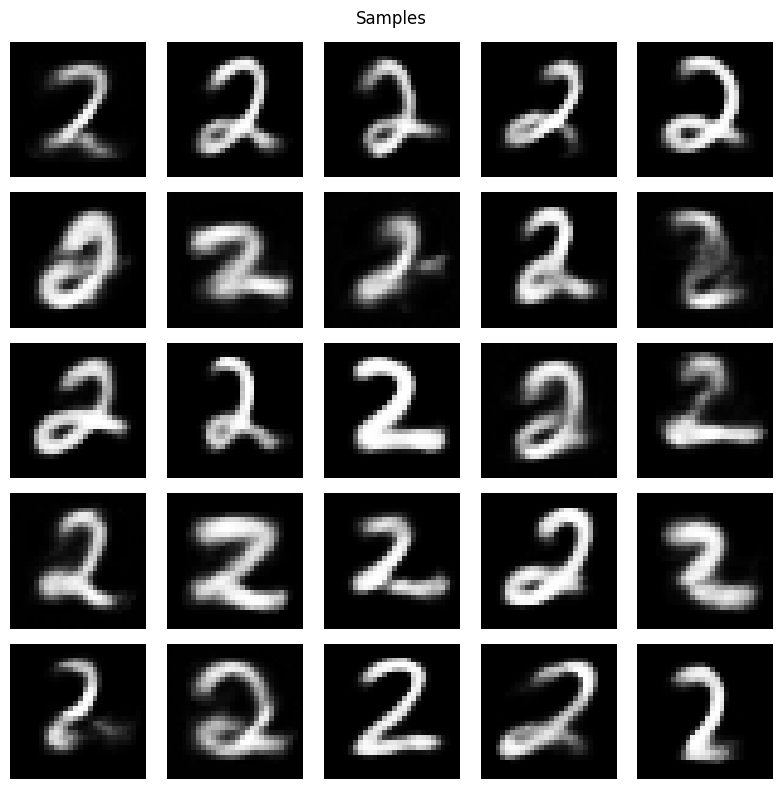

In [34]:
make_2 = number_training(2,train_dataset)

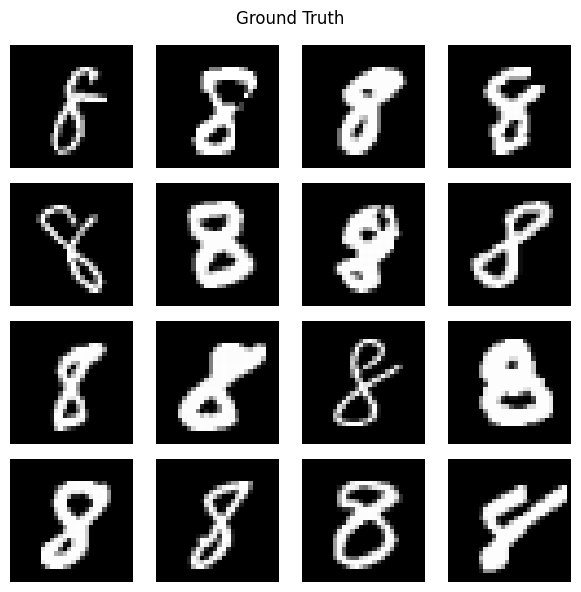

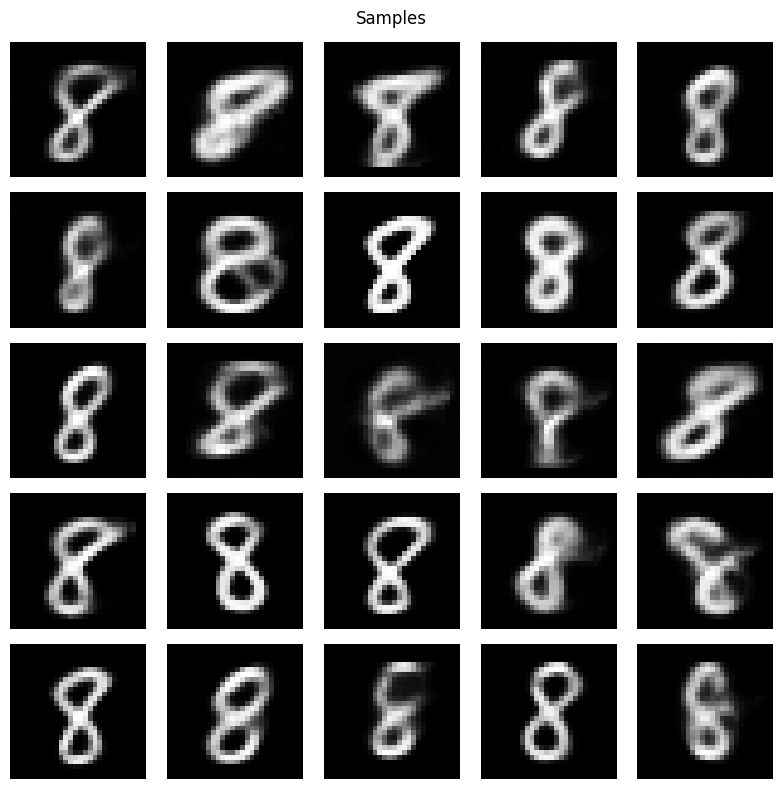

In [31]:
make_8 = number_training(8,train_dataset)

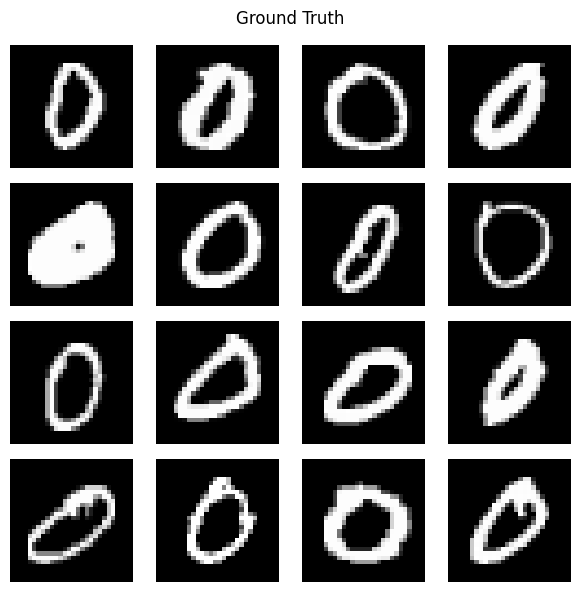

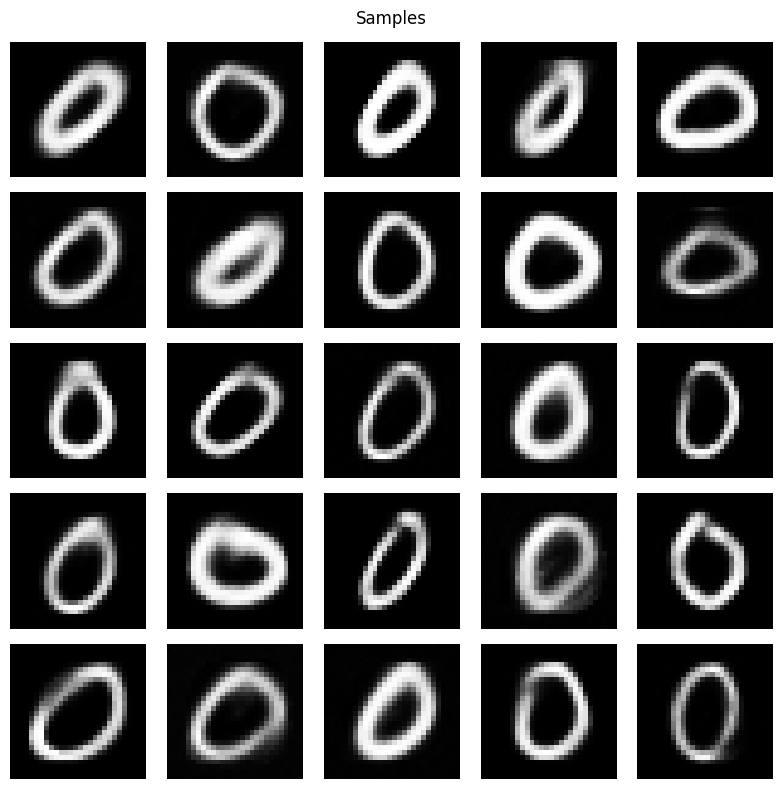

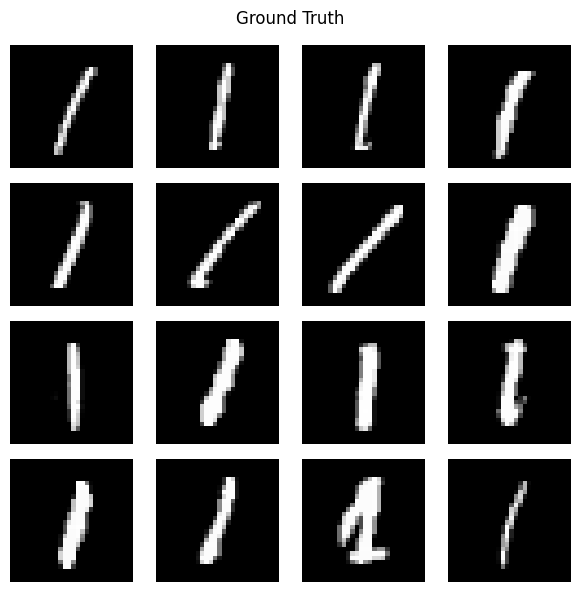

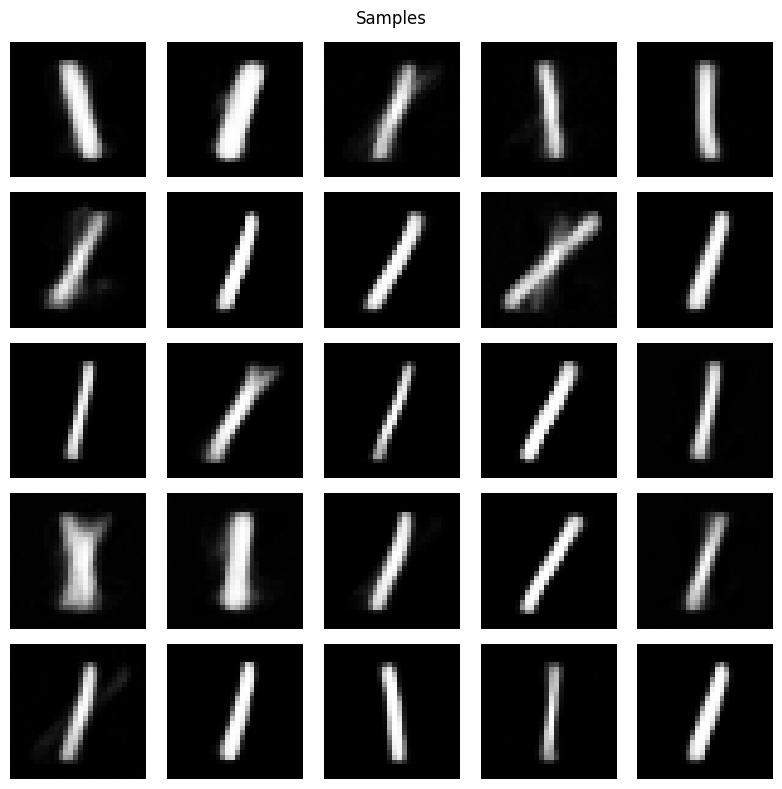

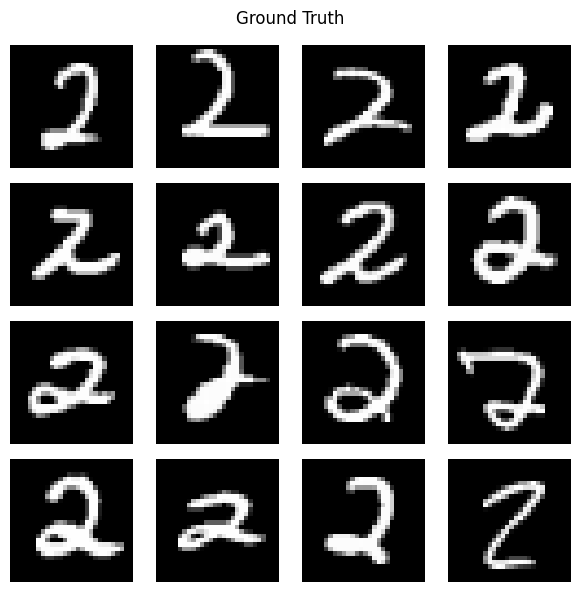

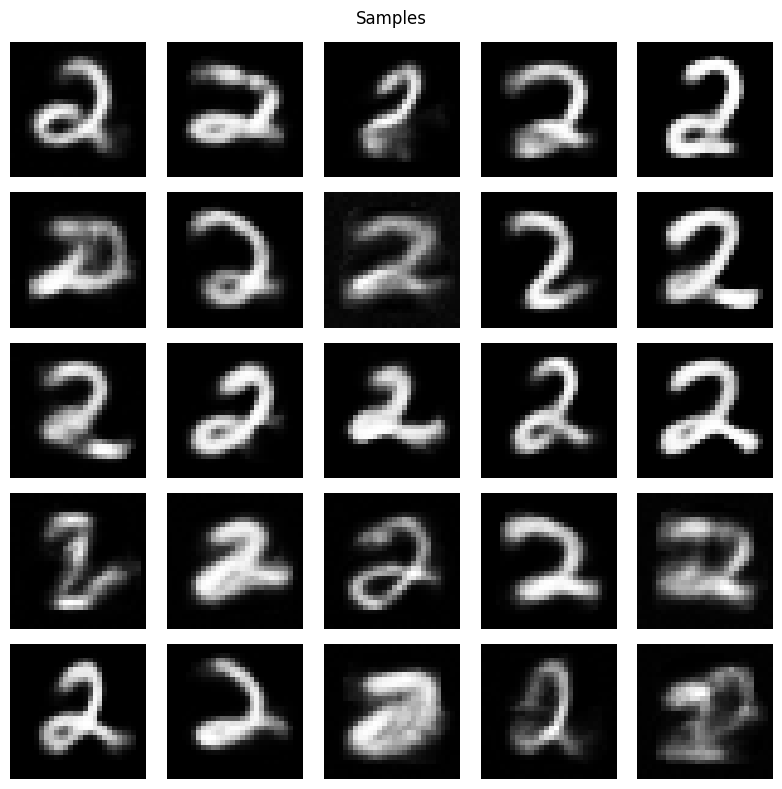

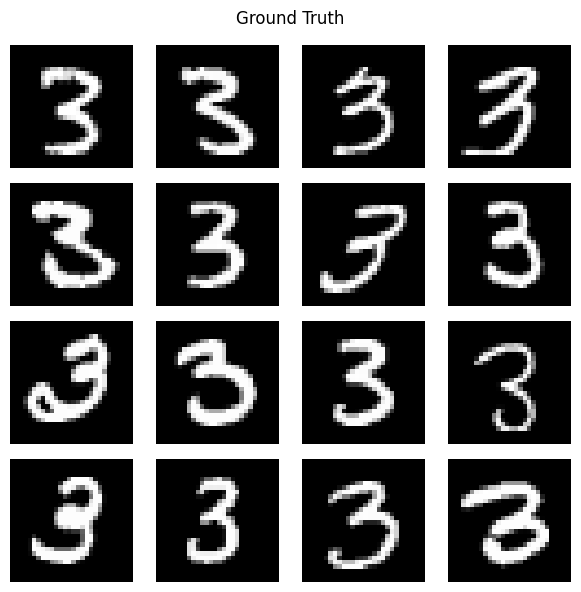

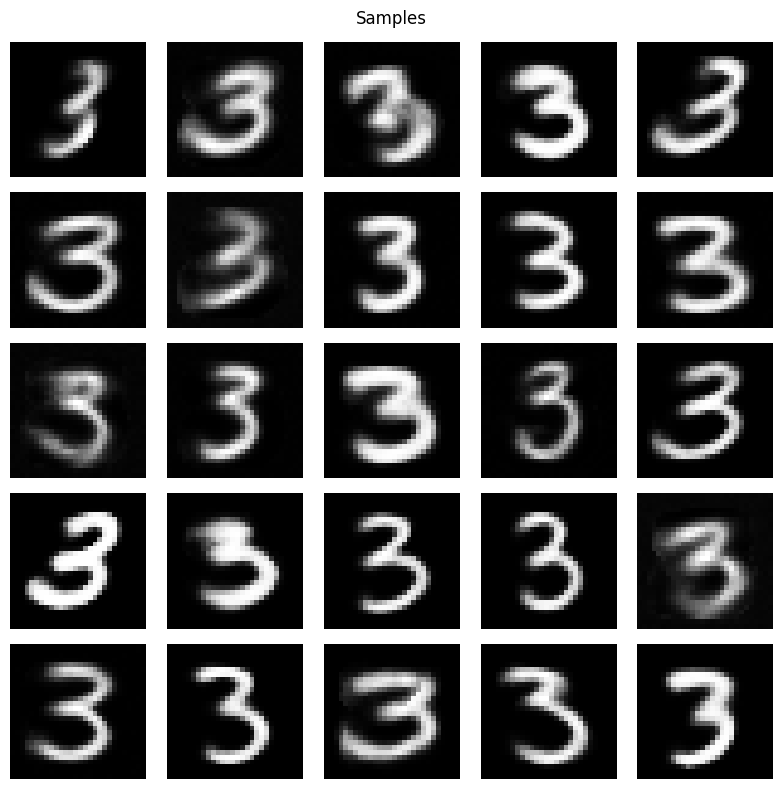

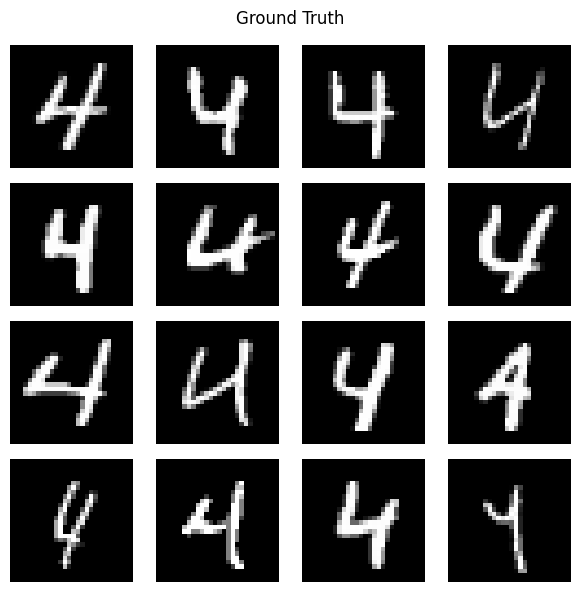

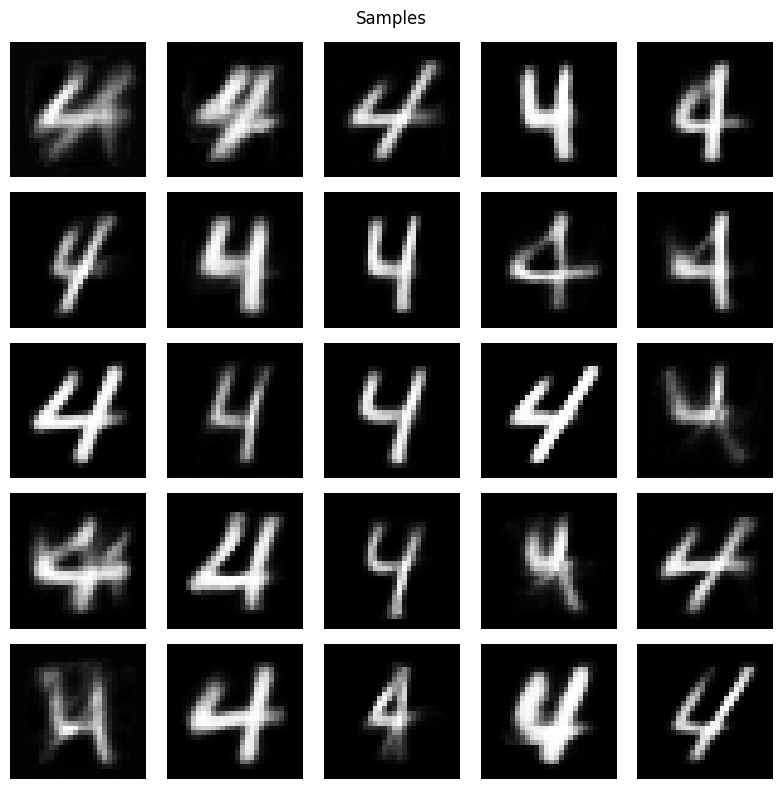

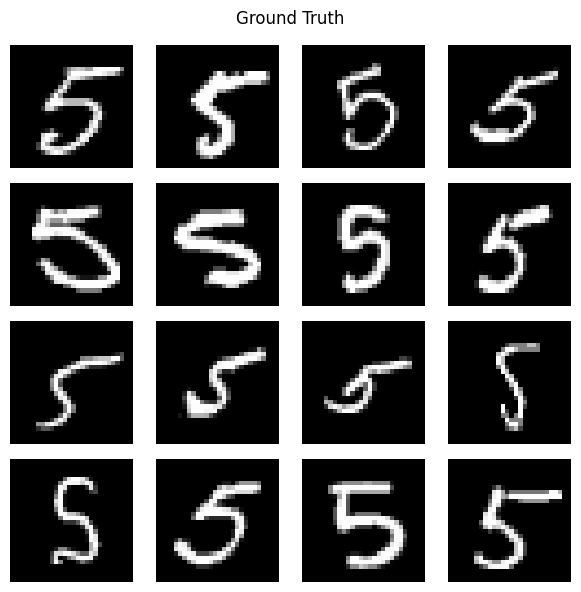

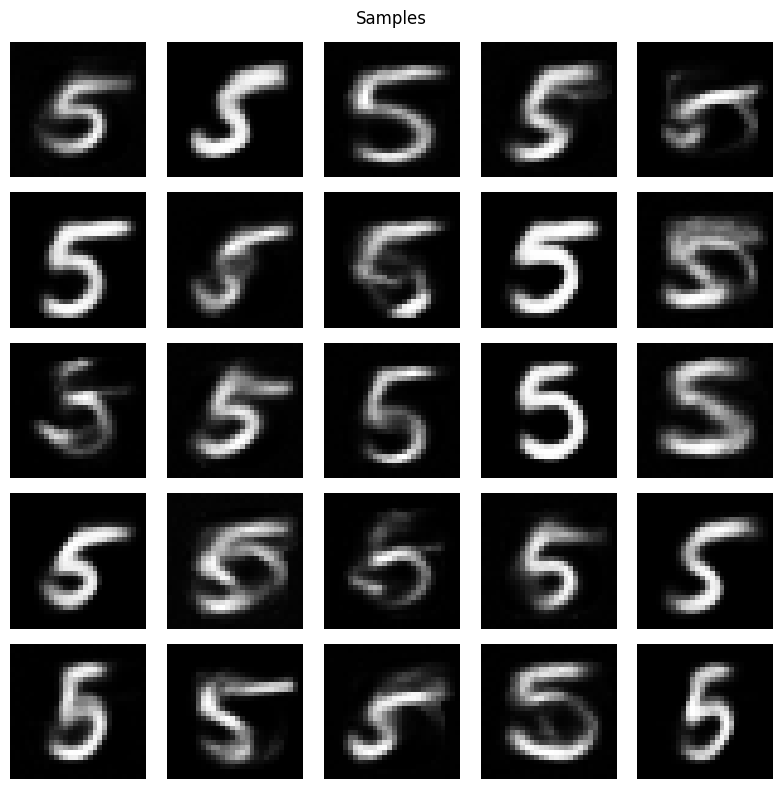

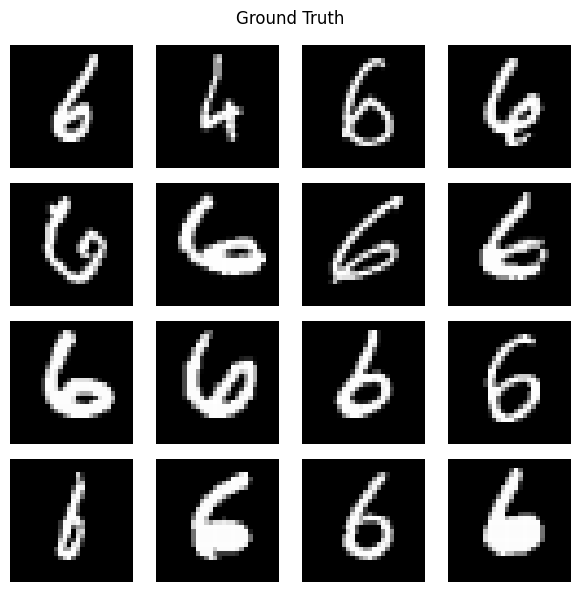

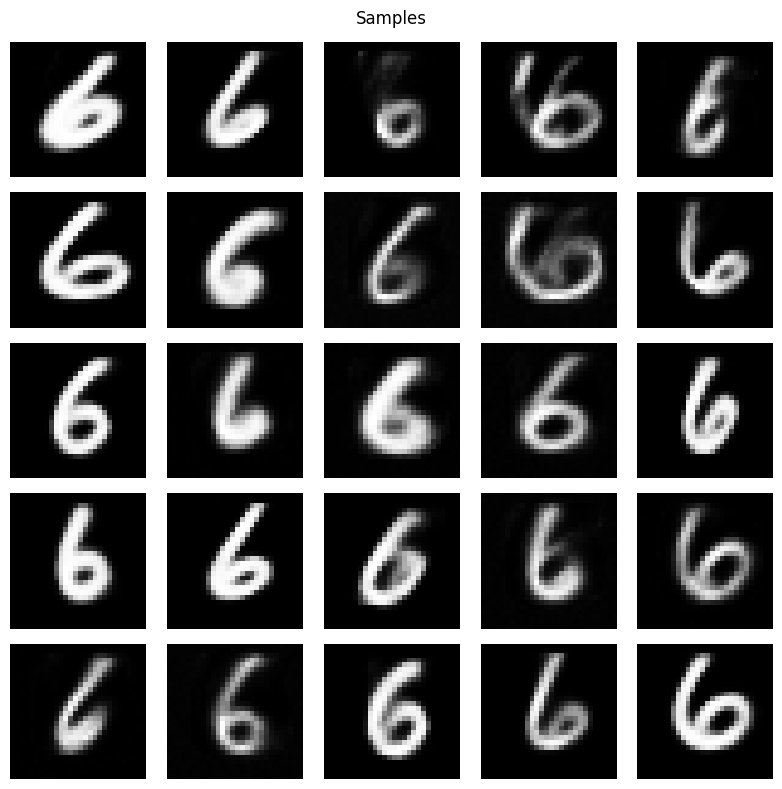

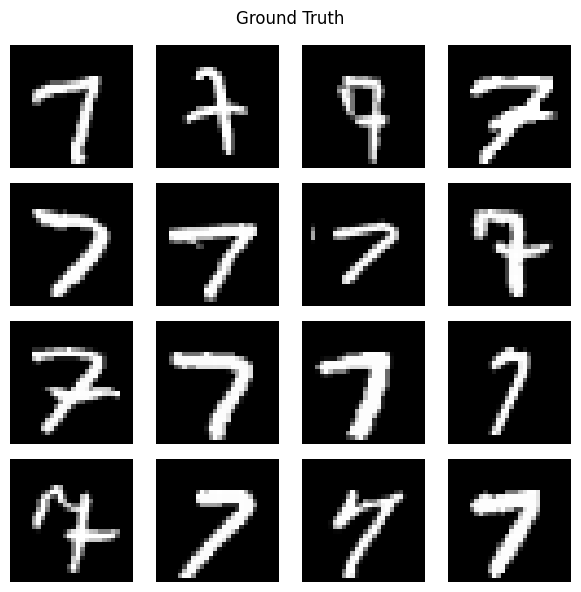

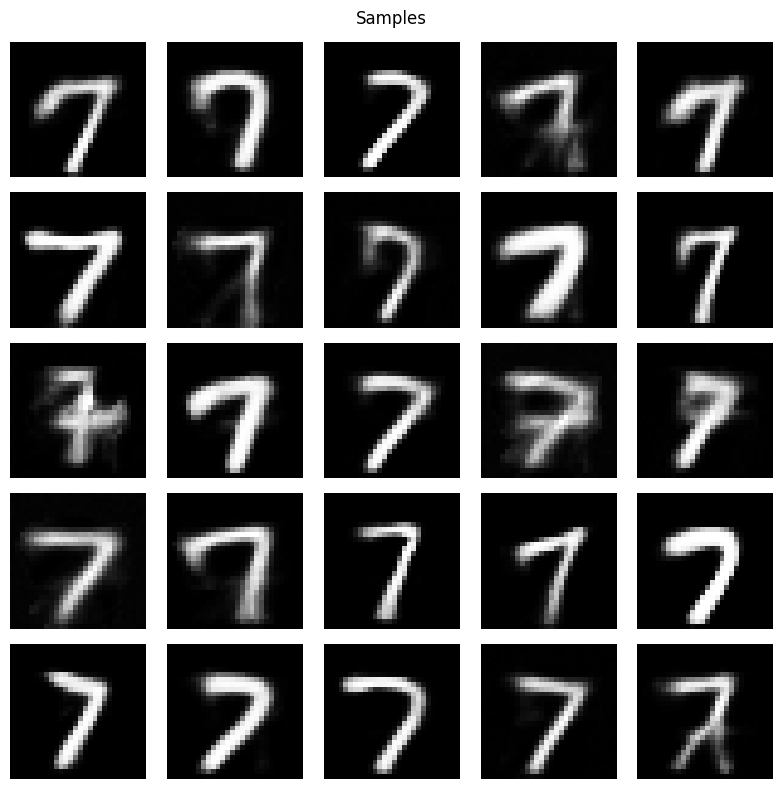

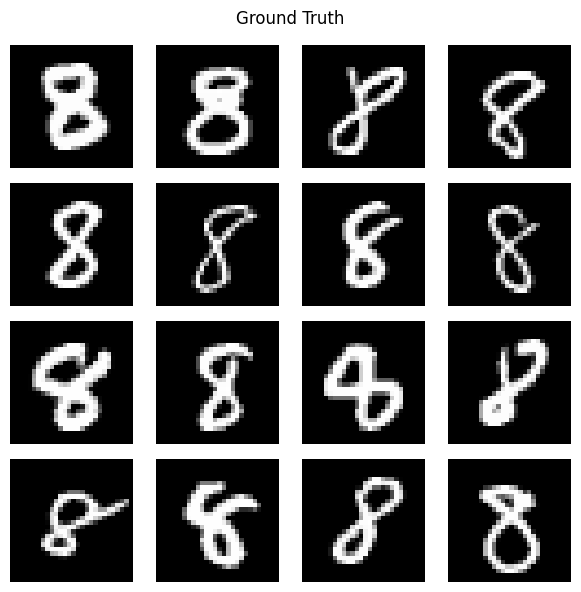

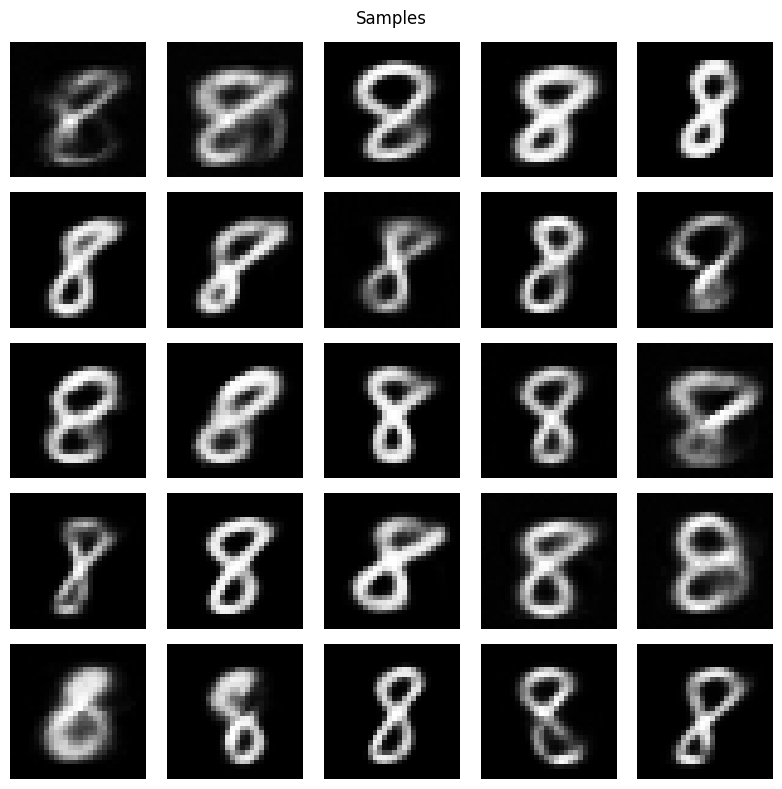

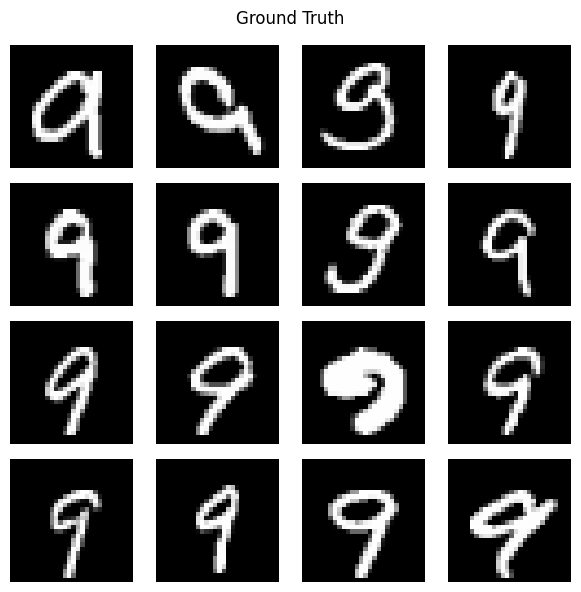

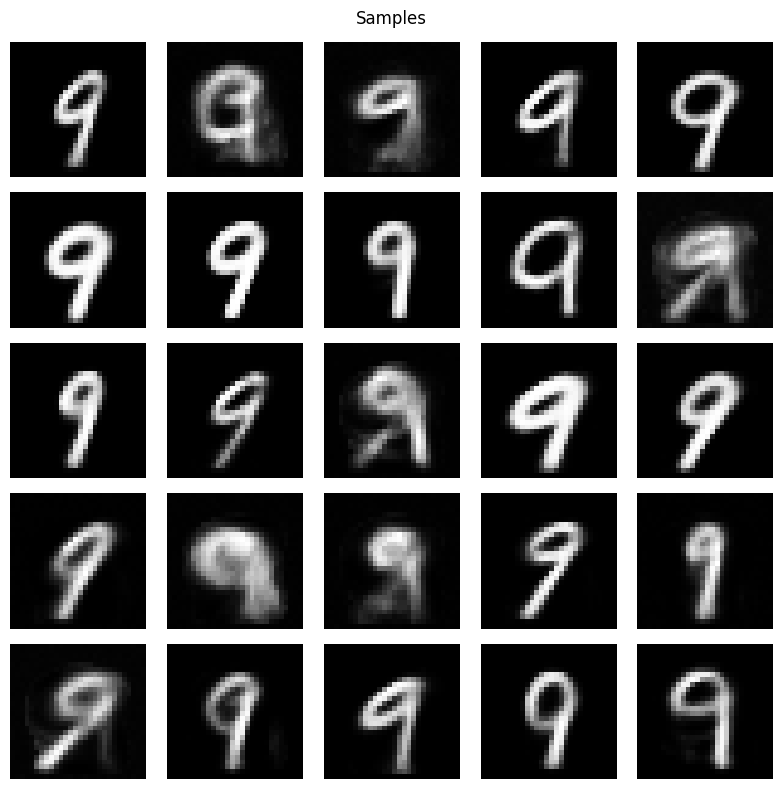

In [32]:
numbers = [0,1,2,3,4,5,6,7,8,9]
for number in numbers:
  number_training(number, train_dataset)

i changed these parameters, adding more epochs seems to improved quality of the samples. not much else. increasing learning rate added more computational time with minimal results
The other dimensions didn't add much.

```
  hidden_dim = 500
  latent_dim = 10
  epochs = 25
  learning_rate = 1e-3
```



3. (2 points) Derive the loss function used in the above code from first principles. The starting point is ELBO maximization, which we discussed in the lecture. Start with the form

$$
\text { ELBO } \equiv \mathbb{E}_{x\sim q(x)}\mathbb{E}_{z \sim q_\phi\left(z \mid x\right)}\left[\ln p_\theta\left(x \mid z\right)\right]- D_{\mathrm{KL}}\left(q_\phi\left(z \mid x\right) \| p(z)\right)\;.
$$

We make the following assumptions:
-  The variational posterior $q_\phi(z|x)$ can be modeled as a normal distribution with mean $\mu(x)$ and variance $\sigma^2(x)$. We model $\mu(x)$ and $\ln \sigma^2(x)$ with a neural network (see above code).
- We will model the data likelihood $p(x|d(x))$ as normal distribution with mean $d(x)$ and variance one, where $d(x)$ is the decoder output.
- We assume that the prior $p(z)$ is a standard normal distribution.

YOUR ANSWER HERE

**Usage** of AI: *COMMENT HERE*